In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)

                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


## Feature Importance Techniques

### Random Forest Feature Importance Scoring

In [4]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
Agency                     0.559780
WorkflowStatus             0.173468
UWDecision                 0.118432
CommDateProvided           0.033788
SignedDecReceived          0.013722
NoOfLives                  0.013316
ProductGroup               0.011579
SeriousIllnessType         0.011124
BonusCommission            0.011008
Product                    0.010811
CommissionTerms            0.010571
Indexation                 0.009274
ProductType                0.006298
RenewalSacrificeType       0.004066
CommissionSacrificeType    0.003736
ComissionSacrifice         0.003247
Discount                   0.002656
PaymentFreq                0.002633
FreeCover                  0.000490
dtype: float64


In [5]:
# Select the top-n features based on importance
n = 4 
selected_features = feature_importances[:n].index.tolist()

In [6]:
# Create a new dataset with the selected features
selected_data = df[selected_features + [target]]

In [7]:
# Conduct experiments by training and evaluating the model on different feature combinations
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)
    y_pred_combination = rf_classifier_combination.predict(X_test_combination)

    accuracy = accuracy_score(y_test, y_pred_combination)
    report = classification_report(y_test, y_pred_combination)
    print(f"\nExperiment with {feature_combination} features:")
    print(f"Selected Features: {selected_features_combination}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


Experiment with 1 features:
Selected Features: ['Agency']
Accuracy: 0.779639462054494
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.03      0.06      6973
           1       0.78      0.99      0.88     24480

    accuracy                           0.78     31453
   macro avg       0.67      0.51      0.47     31453
weighted avg       0.73      0.78      0.69     31453


Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Accuracy: 0.7996057609766953
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.35      0.44      6973
           1       0.83      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.64      0.66     31453
weighted avg       0.78      0.80      0.78     31453


Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Accuracy: 0.8020

#### Try different test sizes and different n estimators

In [8]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2, 0.25, 0.3, 0.33]
n_estimators_values = [50, 100, 150, 200]
n_values = [4,5,6,7]

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Print feature importances for the current test size and n estimator value
        print(f"\nTest Size: {test_size}, n_estimators: {n_estimators_value}")
        print("Feature Importances:")
        print(feature_importances)

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            report = classification_report(y_test, y_pred_selected)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy: {accuracy}")
            print(f"Classification Report:\n{report}")


Test Size: 0.2, n_estimators: 50
Feature Importances:
Agency                     0.560283
WorkflowStatus             0.171679
UWDecision                 0.117542
CommDateProvided           0.036348
NoOfLives                  0.014011
SignedDecReceived          0.013423
ProductGroup               0.012310
Product                    0.011039
BonusCommission            0.010791
SeriousIllnessType         0.010695
CommissionTerms            0.010358
Indexation                 0.009120
ProductType                0.005754
RenewalSacrificeType       0.003982
CommissionSacrificeType    0.003621
ComissionSacrifice         0.003282
Discount                   0.002636
PaymentFreq                0.002599
FreeCover                  0.000528
dtype: float64
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017359234413252
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017995103805678
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.66     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8006867389438209
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.92      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.67     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'Co

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8013277037338488
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.39      0.46      8650
           1       0.84      0.92      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.71      0.65      0.67     39316
weighted avg       0.78      0.80      0.79     39316

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives', 'SignedDecReceived']
Accuracy: 0.7971055041204599
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.39      0.46      8650
           1       0.84      0.91      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.70      0.65      0.67     39316
weighted avg       0.78      0.80      0.78     39316

Selected Features: ['Agency', '

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
Accuracy: 0.7963288751351236
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.46     10413
           1       0.84      0.91      0.87     36766

    accuracy                           0.80     47179
   macro avg       0.70      0.65      0.67     47179
weighted avg       0.78      0.80      0.78     47179

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission']
Accuracy: 0.7916021958922402
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     10413
           1       0.84      0.90      0.87     36766

    accuracy                           0.79     47179
   macro avg       0.69      0.65      0.67     47179
weighted avg       0.77      0.79      0.78   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
Accuracy: 0.7922037882729253
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     11494
           1       0.84      0.90      0.87     40403

    accuracy                           0.79     51897
   macro avg       0.69      0.65      0.67     51897
weighted avg       0.77      0.79      0.78     51897


Test Size: 0.33, n_estimators: 100
Feature Importances:
Agency                     0.564858
WorkflowStatus             0.175017
UWDecision                 0.108815
CommDateProvided           0.033528
SignedDecReceived          0.013987
NoOfLives                  0.013651
SeriousIllnessType         0.011698
BonusCommission            0.011642
ProductGroup               0.011488
Product                    0.011156
CommissionTerms            0.010968
Indexation                 0.009743


In [11]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

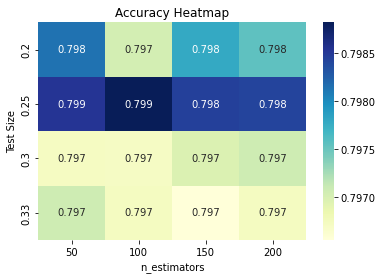

In [22]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

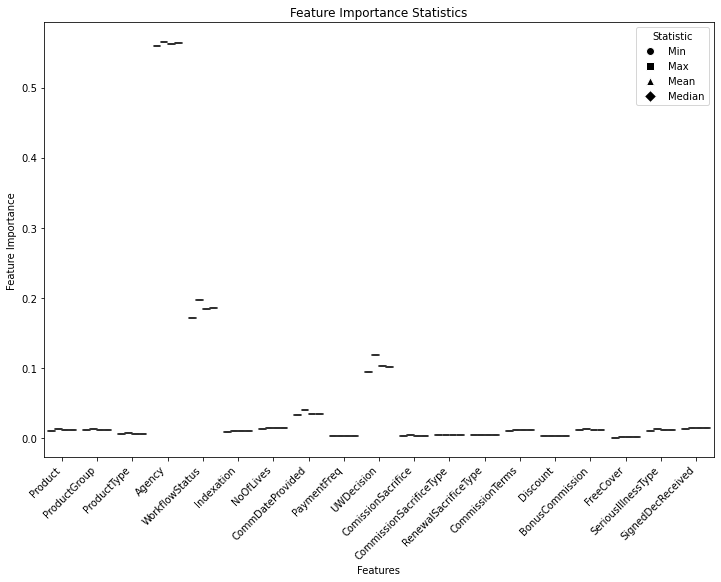

In [46]:
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Reshape DataFrame for box plot
feature_importance_stats_df = feature_importance_stats_df.reset_index().melt(id_vars='index', var_name='Statistic', value_name='Importance')

# Define markers for each statistic
marker_dict = {'Min': 'o', 'Max': 's', 'Mean': '^', 'Median': 'D'}

# Convert hue_order to a list explicitly
hue_order = ['Min', 'Max', 'Mean', 'Median']

# Visualize Feature Importance Statistics with Box Plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=feature_importance_stats_df, x='index', y='Importance', hue='Statistic', hue_order=hue_order, 
            palette='colorblind', showmeans=True, meanprops=dict(marker=''))

plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Statistics")

# Set marker styles for each statistic using hue_kws
for stat, marker in marker_dict.items():
    hue_kws = {"marker": marker, "markersize": 35}
    for line in plt.gca().get_lines():
        if line.get_label() == stat:
            line.update(hue_kws)

# Add custom legend with markers
legend_handles = [plt.Line2D([0], [0], marker=marker_dict[stat], color='w', label=stat, markerfacecolor='black', markersize=8) for stat in hue_order]
plt.legend(handles=legend_handles, title="Statistic", loc='upper right')

plt.show()

The feature importance scoring built into random forest appears to be suggesting that the same four independent variables as identifed with Cramer's V are the most important predictors of Policy Issuance.

### Gradient Boosting Feature Importance Scoring

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Gradient Boosting classifier
        gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Print feature importances for the current test size and n estimator value
        print(f"\nTest Size: {test_size}, n_estimators: {n_estimators_value}")
        print("Feature Importances:")
        print(feature_importances)

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
            gb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = gb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            report = classification_report(y_test, y_pred_selected)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy: {accuracy}")
            print(f"Classification Report:\n{report}")


Test Size: 0.2, n_estimators: 50
Feature Importances:
WorkflowStatus             0.720592
Agency                     0.126609
UWDecision                 0.064552
ProductGroup               0.028930
CommDateProvided           0.016762
NoOfLives                  0.012068
BonusCommission            0.010318
Product                    0.009679
ProductType                0.006049
SignedDecReceived          0.003814
Indexation                 0.000385
PaymentFreq                0.000145
CommissionTerms            0.000097
ComissionSacrifice         0.000000
CommissionSacrificeType    0.000000
RenewalSacrificeType       0.000000
Discount                   0.000000
FreeCover                  0.000000
SeriousIllnessType         0.000000
dtype: float64
Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup']
Accuracy: 0.7965853813626681
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.18      0.28      6973
       

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup']
Accuracy: 0.7995421740374528
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.24      0.35      6973
           1       0.82      0.96      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.72      0.60      0.62     31453
weighted avg       0.77      0.80      0.76     31453

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided']
Accuracy: 0.8000190760817728
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.33      6973
           1       0.81      0.96      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.73      0.59      0.61     31453
weighted avg       0.77      0.80      0.76     31453

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'Pro

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided']
Accuracy: 0.8008698748601079
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.21      0.32      8650
           1       0.81      0.97      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.73      0.59      0.60     39316
weighted avg       0.78      0.80      0.76     39316

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product']
Accuracy: 0.8013785736087089
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.24      0.34      8650
           1       0.82      0.96      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.72      0.60      0.61     39316
weighted avg       0.78      0.80      0.76     39316

Selected Features: ['WorkflowStatus

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product']
Accuracy: 0.7998473897284809
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.21      0.32     10413
           1       0.81      0.97      0.88     36766

    accuracy                           0.80     47179
   macro avg       0.73      0.59      0.60     47179
weighted avg       0.77      0.80      0.76     47179

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission']
Accuracy: 0.7998897814705695
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.22      0.33     10413
           1       0.81      0.96      0.88     36766

    accuracy                           0.80     47179
   macro avg       0.72      0.59      0.60     47179
weighted avg       0.77      0.80      0.76     47179


Test

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission']
Accuracy: 0.7980615449833324
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.19      0.29     11494
           1       0.81      0.97      0.88     40403

    accuracy                           0.80     51897
   macro avg       0.73      0.58      0.59     51897
weighted avg       0.77      0.80      0.75     51897


Test Size: 0.33, n_estimators: 100
Feature Importances:
WorkflowStatus             0.710572
Agency                     0.134734
UWDecision                 0.066794
ProductGroup               0.027708
CommDateProvided           0.017328
Product                    0.014294
BonusCommission            0.009690
NoOfLives                  0.009443
SignedDecReceived          0.004492
ProductType                0.002743
Indexation                 0.000721
CommissionTerms            0.000578
Seri